<a href="https://colab.research.google.com/github/SonakshiA/Is-It-a-Hotdog-/blob/main/Hot_Dog_vs_Not_Hot_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

Citation

@inproceedings{bossard14,
  title = {Food-101 -- Mining Discriminative Components with Random Forests},
  author = {Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc},
  booktitle = {European Conference on Computer Vision},
  year = {2014}
}

In [4]:
ds, ds_info = tfds.load('food101',shuffle_files=True, as_supervised = True, with_info = True) #returns a tuple

In [9]:
train_ds, validation_ds = ds['train'],ds['validation']

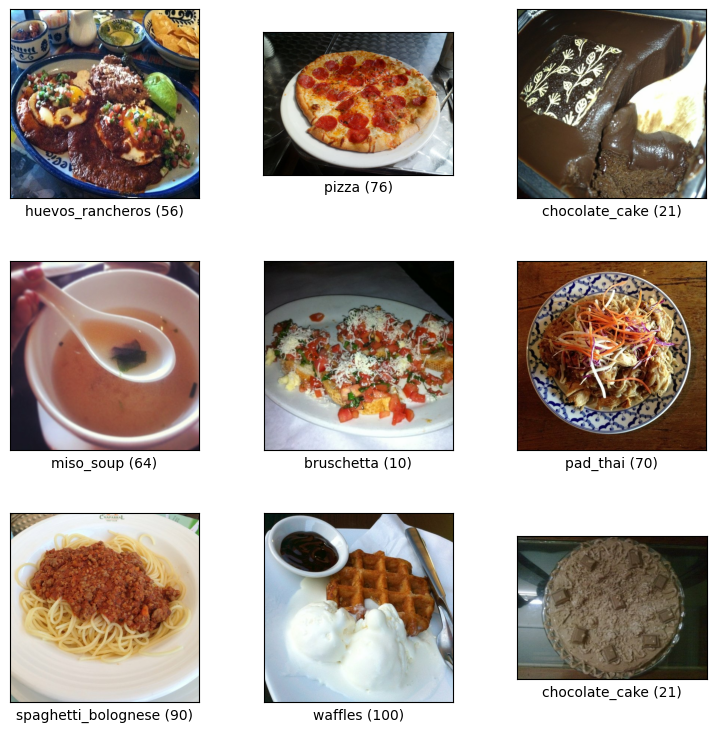

In [13]:
fig = tfds.show_examples(train_ds,ds_info)

In [14]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label : (tf.cast(tf.image.resize(image,[MAX_SIDE_LEN,MAX_SIDE_LEN]),dtype=tf.int32),label == HOT_DOG_CLASS)
) #map(<filter>) applies the function to every single item in the dataset

validation_ds = validation_ds.map(
    lambda image, label : (tf.cast(tf.image.resize(image,[MAX_SIDE_LEN,MAX_SIDE_LEN]),dtype=tf.int32),label == HOT_DOG_CLASS)
) #map(<filter>) applies the function to every single item in the dataset

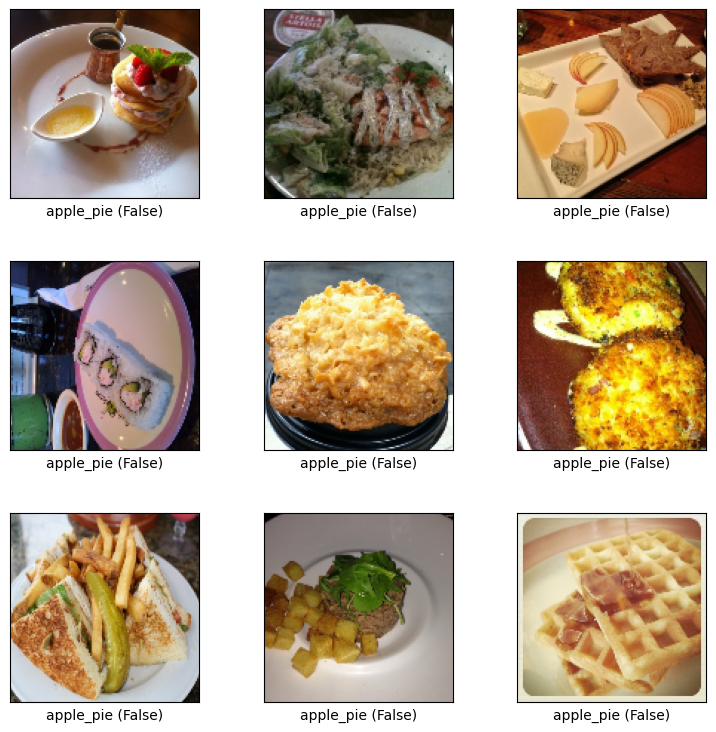

In [21]:
fig = tfds.show_examples(train_ds,ds_info)

In [22]:
train_hd_size, validation_hd_size = 750,250 #sizes
train_hotdogs = train_ds.filter(lambda image, label: label==True).repeat(3) #repeat to get more hotdogs in a new dataset for better training and validation
train_nothotdogs = train_ds.filter(lambda image, label: label==False)

validation_hotdogs = validation_ds.filter(lambda image, label: label==True).repeat(3)
validation_nothotdogs = validation_ds.filter(lambda image, label: label==False)

**cache()** : store Dataset in memory/local storage. Saves operations such as file opening and reading everytime the neural net is run

**batch()**: pass a bunch of images into the neural net

**prefetch()**: overlaps training of data of one set with the reading for next set to save time

**sample_from_datasets** : takes a few samples from the overall dataset. The nothotdog data overnumbers hotdog datasets even tho we've repeated. Thus, we still need to create a new balanced dataset

In [24]:
batch_size=16

train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs,train_nothotdogs],weights=[0.5,0.5],stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)


validation_ds = tf.data.Dataset.sample_from_datasets([validation_hotdogs,validation_nothotdogs],weights=[0.5,0.5],stop_on_empty_dataset=True)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [25]:
for image_batch, lable_batch in train_ds.take(1): #take(1) specifies only one sample
  print(image_batch)
  print(lable_batch)

tf.Tensor(
[[[[253 255 254]
   [253 254 253]
   [254 254 252]
   ...
   [254 254 254]
   [255 255 255]
   [255 255 255]]

  [[253 254 253]
   [253 255 254]
   [253 255 254]
   ...
   [252 252 252]
   [253 253 253]
   [255 255 255]]

  [[255 255 253]
   [253 255 254]
   [236 240 241]
   ...
   [ 30  30  30]
   [254 254 254]
   [255 255 255]]

  ...

  [[254 254 252]
   [253 253 250]
   [125 120 116]
   ...
   [114 114 117]
   [254 254 254]
   [255 255 253]]

  [[255 255 253]
   [252 254 251]
   [253 253 250]
   ...
   [252 252 252]
   [254 254 254]
   [255 255 254]]

  [[254 255 253]
   [252 255 253]
   [250 254 251]
   ...
   [254 254 252]
   [254 254 253]
   [255 255 255]]]


 [[[145 100  33]
   [147 102  34]
   [147 102  34]
   ...
   [146 111  55]
   [145 110  53]
   [145 110  53]]

  [[146 101  33]
   [146 101  33]
   [148 103  34]
   ...
   [145 108  55]
   [143 107  54]
   [142 107  54]]

  [[151 106  37]
   [154 109  40]
   [151 107  36]
   ...
   [150 113  57]
   [151 114  60]


# **Neural Network Implementation**

In [37]:
#to prevent overfitting
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

In [32]:
for i,_ in ds['train'].take(1):
  image = i

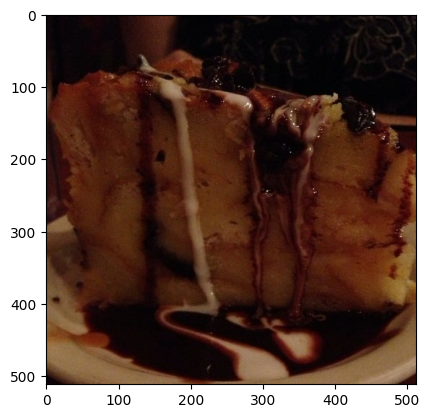

In [33]:
plt.imshow(image)

In [34]:
image = tf.cast(tf.expand_dims(image,0),tf.float32)
image/=255.0


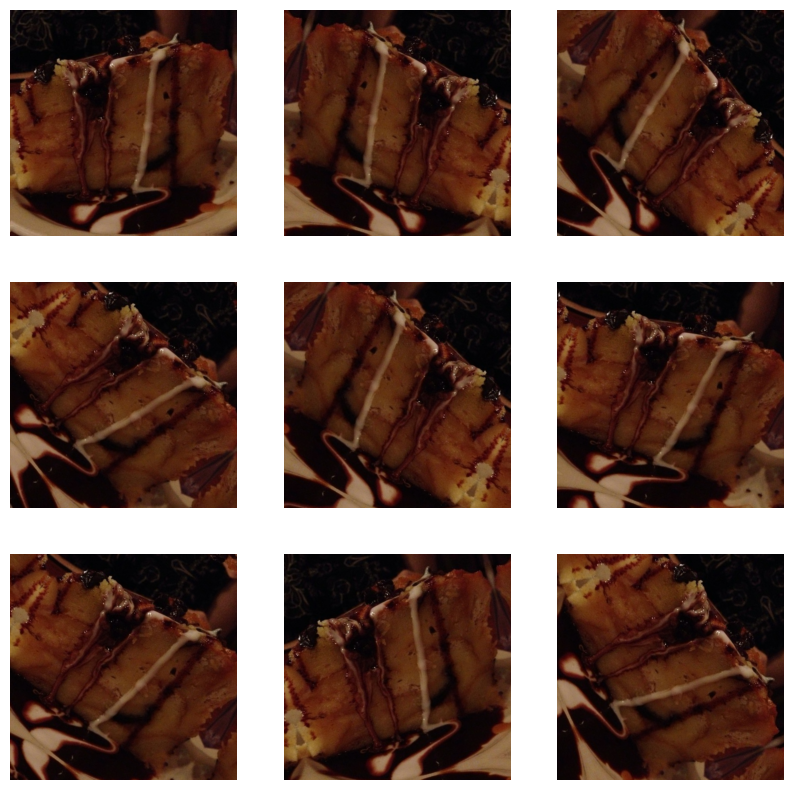

In [38]:
#scrabling the dataset a bit
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3,3,i+1) #rows, columns and label
  plt.imshow(augmented_image[0]) #augmented_image is a container so we need to use indexing
  plt.axis('off')

model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape = [MAX_SIDE_LEN,MAX_SIDE_LEN,3]))

128: Number of filters
(3,3): Kernel/Filter size
activation: 'relu' . This is the activation function used
input_hspae = [,,3]. 3 denotes number of colors (RGB)


In [42]:
random.seed(0) #enables you to provide a seed (i.e., the starting input) for NumPy's pseudo-random number generator. Creates repeatable output
model = models.Sequential()
model.add(layers.Rescaling(1./255)) #getting results between 0 and 1 instead of 0 to 255 for all the colors
model.add(data_augmentation)
model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape = [MAX_SIDE_LEN,MAX_SIDE_LEN,3]))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer = tf.keras.regularizers.l2(l=0.01))) #l2 creates bigger penalty for bigger weights since it uses the squares
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu')) #Dense(128) is a fully connected layer
model.add(layers.Dense(1)) #it is binary classification, so we need only one output neuron at the end of the neural network that gives the result

In [43]:
lr = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(lr),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
#optimizer: tool to help us adjust the different weights to get minimum loss
#from_logits = True signifies the values of the loss obtained by the model are not normalized i.e not between 0 and 1

In [44]:
epochs = 10
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=epochs,
                    verbose=1)

Epoch 1/10
280/280 [==============================] - 180s 635ms/step - loss: 1.5276 - accuracy: 0.4987 - val_loss: 1.1813 - val_accuracy: 0.5063
Epoch 2/10
280/280 [==============================] - 168s 599ms/step - loss: 1.0056 - accuracy: 0.5007 - val_loss: 0.8757 - val_accuracy: 0.5063
Epoch 3/10
280/280 [==============================] - 166s 593ms/step - loss: 0.8095 - accuracy: 0.5217 - val_loss: 0.7664 - val_accuracy: 0.5063
Epoch 4/10
280/280 [==============================] - 167s 596ms/step - loss: 0.7390 - accuracy: 0.5286 - val_loss: 0.7195 - val_accuracy: 0.5095
Epoch 5/10
280/280 [==============================] - 167s 596ms/step - loss: 0.7057 - accuracy: 0.5485 - val_loss: 0.6920 - val_accuracy: 0.5247
Epoch 6/10
280/280 [==============================] - 158s 563ms/step - loss: 0.6911 - accuracy: 0.5531 - val_loss: 0.6851 - val_accuracy: 0.5194
Epoch 7/10
280/280 [==============================] - 166s 592ms/step - loss: 0.6797 - accuracy: 0.5665 - val_loss: 0.6657 -

The validation data is not passed into the neural network for training. This is the unseen data.

If the training accuracy is very high and validation accuracy is low, it means that overfitting/overtraining has occurred

To prevent this, we make some changes to our model:
1. **layers.Dropout(0.25)**: This drops out/deactives 25% of the neurons randomly i.e ignores them during the training

2. **data_augmentation**: We augment/change the data. This serves two benefits - increase the dataset and also prevents overfitting

3. **kernal_regularizer**: This parameter enforces a penalty when the weights are too large (that may cause overfitting)
L1 regularization considers the weight of the layers as it is while the L2 regularization considers the squares of weights.

The L1 regularization penalty is computed as: loss = l1 * reduce_sum(abs(x))
The L2 regularization penalty is computed as: loss = l1 * reduce_sum(square(x))

In [50]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in validation_ds.take(1):
  images = image_batch
  labels = label_batch


<Figure size 1000x1000 with 0 Axes>

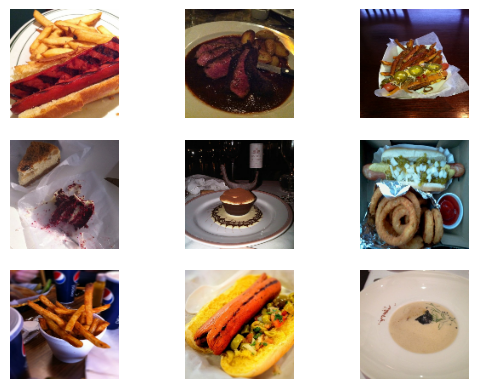

In [51]:
for i in range(9):
  ax = plt.subplot(3,3,i+1) #rows, columns and label
  plt.imshow(images[i]) #augmented_image is a container so we need to use indexing
  plt.axis('off')

In [52]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=bool, numpy=array([ True, False,  True, False, False,  True, False,  True, False])>